In [1]:
import numpy as np
import torch
import torchvision
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt

from segment_anything.utils.transforms import ResizeLongestSide

from datasets import Embedding_Dataset
from utils import SAMPreprocess, PILToNumpy, NumpyToTensor, sample_point, embedding_collate
from models import SAM_Baseline
from test import create_dataloaders, test_model, plot_iou_scores

In [2]:
folder_paths = [
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/Liebherr/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/EgoHOS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/GTEA/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/LVIS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/NDIS Park/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/TrashCan/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/ZeroWaste-f/dataset',
]
only_liebherr = True
load_weights = 'Fine-Tune-SAM.pth'
only_test = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAM_Baseline()
if load_weights is not None:
    model.load_state_dict(torch.load(load_weights))
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)
print("Let's go")

Let's go


In [4]:
sam_transform = ResizeLongestSide(model.img_size)
target_transform = Compose([
    sam_transform.apply_image_torch, # rescale
    SAMPreprocess(model.img_size, normalize=False), # padding
    sample_point,
])
transform = Compose([
    PILToNumpy(),
    sam_transform.apply_image, # rescale
    NumpyToTensor(),
    SAMPreprocess(model.img_size) # padding
])

if only_liebherr:
    folder_paths = [folder_paths[0]]
    
dataloaders = create_dataloaders(folder_paths, transform=transform, target_transform=target_transform, collate_fn=embedding_collate,
                                 batch_size=8, only_test=only_test)

In [5]:
iou_scores, oracle_iou_scores, dataset_names = test_model(model, dataloaders, device)

Testing Liebherr


100%|██████████| 16/16 [01:11<00:00,  4.49s/it, IoU=0.596, oracle IoU=0.7]  


Average IoU tensor(0.5961)
Average Oracle IoU tensor(0.6998)


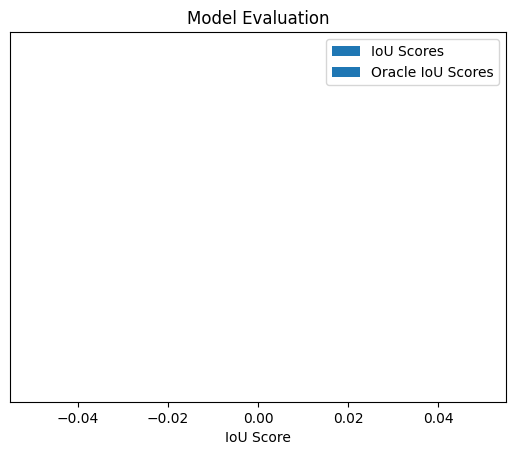

nan nan


/home/ul/ul_student/ul_xto11/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ul/ul_student/ul_xto11/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
plot_iou_scores(iou_scores[1:], oracle_iou_scores[1:], dataset_names[1:])
print(np.mean(iou_scores[1:]), np.mean(oracle_iou_scores[1:]))